In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde
from torch.utils.data import Dataset

import glob
from glob import glob
import nibabel as nb
import gzip

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.manual_seed_all(42)

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B
class mriDataset(Dataset):
    def __init__(self, input_dir):
        self.mri_files = glob(input_dir+'/*/m*')
    
    def __getitem__(self,idx):
        vol = round(idx/80)
        mri_vol = gzip.GzipFile(self.mri_files[vol],'r');
        
        slice = idx-vol*80;
        mri_img = torch.from_numpy(np.load(mri_vol)[:,:,150+slice])     # get slice from volume
        
        # transforms
        mri_img = mri_img/torch.max(mri_img).item()                     # normalize
        mri_img = mri_img + (0.001**0.5)*torch.randn(256,320)           # add noise

        return mri_img
    
class sosDataset(Dataset):
    def __init__(self, input_dir):
        self.sos_files = glob(input_dir+'/*/V*')
    
    def __getitem__(self,idx):
        vol = round(idx/80)
        sos_vol = gzip.GzipFile(self.sos_files[vol],'r');
        
        slice = idx-vol*80;
        sos_img = torch.from_numpy(np.load(sos_vol)[:,:,150+slice])     # get slice from volume

        # transforms
        sos_img = sos_img/torch.max(sos_img).item()                     # normalize
        sos_img = sos_img + (0.001**0.5)*torch.randn(256,320)           # add noise

        return sos_img


def init_dataset(bs, test=False):
    if(test == False): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train';
    if(test == True): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/test';
    dataloader_mri = mriDataset(path);
    dataloader_sos = sosDataset(path);
    
    return dataloader_mri, dataloader_sos


The code will run on GPU.


In [3]:
G_A2B, G_B2A, D_A, D_B = load_models('230323')

test_mris = []
test_soss = []
ns = []
count = 0

test_dataloader_mri, test_dataloader_sos = init_dataset(1, True)                            # dataloader for test images

iter_mri_test = iter(test_dataloader_mri);
iter_sos_test = iter(test_dataloader_sos);

for count in range(1,500,100):
    test_mris.append(next(iter_mri_test))
    test_soss.append(next(iter_sos_test))
print("Number of test images: "+str(len(test_mris)))


Number of test images: 5


In [7]:
# generate fake imgs
test_fake_mris = []
test_fake_soss = []
test_rec_mris = []
test_rec_soss = []

G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
for i in range(len(test_mris)):
    real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0).float()
    fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
    rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

    real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0).float()
    fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
    rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

    test_fake_mris.append(fake_mri)
    test_fake_soss.append(fake_sos)
    test_rec_mris.append(rec_mri)
    test_rec_soss.append(rec_sos)

    with torch.no_grad():
        real_mri.detach().cpu()
        real_sos.detach().cpu()
n=2
print(test_soss[n].shape, test_fake_soss[n].shape)


test_mris_np = []
test_soss_np = []
test_fake_mris_np = []
test_fake_soss_np = []
for i in range(len(test_mris)):
    test_mris_np.append(test_mris[i].cpu().detach().numpy())
    test_soss_np.append(test_soss[i].cpu().detach().numpy())


torch.Size([256, 320]) (1, 1, 256, 320)


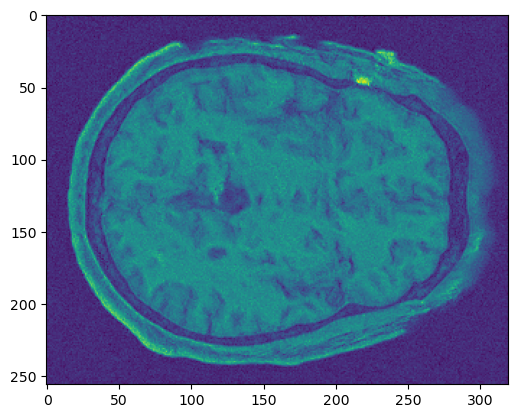

In [19]:
plt.imshow(test_fake_mris[1][0,0,:,:])

In [10]:
for i in range(1, len(test_mris)):
    diff_mri = test_mris[i] - test_fake_mris[i]

diff_mri = (test_mris-test_fake_mris)[73:193,66:216]
diff_sos = (test_soss-test_fake_soss[0,0,:,:])[73:193,66:216]
plt.imshow(diff_mri[n]);plt.colorbar();plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:

avg_realmri = np.mean(np.array(test_mris_np[:]),axis=0).flatten()
avg_fakemri = np.mean(np.array(test_fake_mris[:]),axis=0).flatten()
avg_realsos = np.mean(np.array(test_soss_np[:]),axis=0).flatten()
avg_fakesos = np.mean(np.array(test_fake_soss[:]),axis=0).flatten()
print(np.corrcoef([avg_realmri, avg_fakemri]))
print(np.corrcoef([avg_realsos, avg_fakesos]))

real_mris = torch.mean(torch.Tensor(test_mris)).flatten()
rec_mris = torch.mean(torch.Tensor(test_rec_mris)).flatten()

# plt.imshow(test_mris[1]);plt.colorbar();plt.show()
# xy = np.vstack([real_mris, rec_mris])
# z = gaussian_kde(xy)(xy)
# plt.scatter(real_mris,rec_mris,c=z);plt.show()